# Gridded Data: Remote access of NASA PO.DAAC satellite data
Demonstrate query tools for finding remote sensing gridded data at the [NASA PO.DAAAC](https://podaac.jpl.nasa.gov). Use `xarray` with the `OPeNDATA` remote access protocol to download the desired subsets of data, and `xarray` to explore the data.

- [Emilio Mayorga](https://github.com/emiliom/), University of Washington and NANOOS/IOOS
- [Chelle Gentemann](https://github.com/cgentemann), Earth and Space Researc

[OceanHackWeek 2019](https://oceanhackweek.github.io/)

## Acknowledgments
- Lineage: https://github.com/cgentemann/cloud_science/blob/master/ocean_python_tutorial/Intro_07_Xarray_and_plotting_with_cartopy.ipynb (note that the original url has changed, and the "-features_new" notebook has disappeared)
  - See https://nbviewer.jupyter.org/github/cgentemann/cloud_science/tree/master/Cloud_testing/ and https://nbviewer.jupyter.org/github/cgentemann/cloud_science/tree/master/ocean_python_tutorial/
- Thanks to [Lewis McGibbney](https://github.com/lewismc), NASA PO.DAAC / JPL, for providing `podaacpy` examples.

## TO-DOs
- cartopy: Use a better coastline or land tile image? Or stick with the default I'm using, and point out that it's bad and should be replaced with a different dataset! See https://ocefpaf.github.io/python4oceanographers/blog/2015/06/22/osm/, though it's old
- Add a small set of "additional resources"
    - Mention or link to ocean.pangeo notebook `noaa_ersst_variability.ipynb`
    - xarray and other resources listed in Chelle's original notebook

-------------------

# Import packages

In [1]:
import warnings
warnings.simplefilter('ignore') # filter some warning messages

import datetime
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

In [2]:
from pathlib import Path
import configparser
from lxml import objectify

In [3]:
import podaac.podaac as podaac
# to obtain rich information from PO.DAAC Drive, import and create an instance of Drive
from podaac import drive as podaacdrive

# NASA PO.DAAC SST data
- Let's briefly explore the user-facing applications available at the PO.DAAC web site (https://podaac.jpl.nasa.gov/), including the usual mix of starting with online applications and switching to programmatic access.
- We'll then use the `podaacpy` Python package, https://podaacpy.readthedocs.io

## Query the NASA PO.DAAC catalog with `podaacpy` package, looking for the MUR SST dataset

In [4]:
def get_podaac_datasetid(dresult):
    dresult_xml = objectify.fromstring(dresult)
    # But note that there can be multiple entry instances, so list handling would be needed, generically
    # Actually, the "podaac:datasetId" element would probably be more correct than "id"
    dataset_id = dresult_xml.entry.id.text
    return dataset_id

In [5]:
basepath = Path('.')

In [6]:
# Create an instance of the Podaac class
p = podaac.Podaac()

Authentication credentials are provided in the 'podaac.ini' file, which is passed to the `podaacpy` `Drive` as `d = drive.Drive('podaac.ini', None, None)`. `podaacpy` drive can only read `podaac.ini` from a hard-wired path within the package installation, `site-packages/podaac/tests`. For more flexibility, we'll read the file from a custom path and feed the credential values directly to `Drive`.

In [7]:
with open(basepath / 'podaac.ini', 'r') as f:
    config = configparser.ConfigParser()
    config.read_file(f)
    d = podaacdrive.Drive(None, 
                          config['drive']['urs_username'], 
                          config['drive']['urs_password'])

Let's set the start and times here, so we can reuse them in several queries.

In [8]:
start_time='2018-09-01T00:00:00Z'
end_time='2018-09-15T23:59:59Z'

In [9]:
dresult = p.dataset_search(keyword='mur', start_time=start_time, end_time=end_time)

`dresult` is an XML response as a string. The function below parses the XML metadata to get the `dataset_id`.

In [10]:
dataset_id = get_podaac_datasetid(dresult)
dataset_id

'PODAAC-GHGMR-4FJ04'

Now let's use `dataset_id` and the date-time range to request dataset **granules** (individual images). `items_per_page` is the maximum number of granules  that can be returned. The default is 7.

In [11]:
gresult = p.granule_search(dataset_id=dataset_id,
                           start_time=start_time,
                           end_time=end_time,
                           items_per_page='50')

In [12]:
# podaacpy provides a convenience function which enables easy access to all Drive urls
urls = d.mine_drive_urls_from_granule_search(granule_search_response=gresult)

In [13]:
type(urls), len(urls)

(list, 15)

In [14]:
urls

['https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/244/20180901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/245/20180902090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/246/20180903090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/247/20180904090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/248/20180905090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/249/20180906090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'ht

The filename encodes the granule timestamp, but let's modify the url's into OPeNDAP url's, and then open a dataset remotely and query its timestamp directly.

In [15]:
urls_mur = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') 
            for w in urls]

## Access the dataset metadata and data

* With well designed mdatasets that follow Climate Forecast (CF) conventions, you will usually get coordinates of lat,lon,time which makes it easy to select data and visualize it in different ways.  
* Notice that the time is automatically converted into a np.datetime64 format which can be queried for month, day, etc.  All the variables that are CF compliant are automatically converted (if needed) and read in so that you can immediately start working with the data.  
* Below, you can see that the dimensions are lat, lon, and time
* The coordinates of the datasets are also lat,lon, and time


Use [xr.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) to open the provided url and print out the dataset metadata.
* url is a text string to an online dataset.  When you open a file, you can just use the file name and path or you can just use the url for files that are available online.  If you are running this on the cloud you could even call cloud located data
* Here, we are reading in a global SST dataset called **MUR** from NASA's PO.DAAC
* The data variable (analysed_sst) has the labeled dimensions and metadata attached.  You can see additional metadata (if it exists) by looking at the data variable of interest.
* We'll read the dataset corresponding to the first granule, `urls_mur[0]`.

In [16]:
ds_sst_mur = xr.open_dataset(urls_mur[0])
ds_sst_mur

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2018-09-01T09:00:00
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
  

How large is this dataset? It's important to know this before trying to download it all.

In [17]:
# size in MB
ds_sst_mur.nbytes/1e6 

15551.352004

**That's 15 GB's!** We definitely don't want to download all that data or define processing steps that effectively try to load all the data. So, we'll define a geographical subset.

Let's examine the `analysed_sst` variable.

In [18]:
ds_sst_mur.analysed_sst.attrs

OrderedDict([('long_name', 'analysed sea surface temperature'),
             ('standard_name', 'sea_surface_foundation_temperature'),
             ('units', 'kelvin'),
             ('valid_min', -32767),
             ('valid_max', 32767),
             ('comment',
              '"Final" version using Multi-Resolution Variational Analysis (MRVA) method for interpolation'),
             ('source',
              'MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRR19_G-NAVO, AVHRRMTA_G-NAVO, iQUAM-NOAA/NESDIS, Ice_Conc-OSISAF')])

In [19]:
ds_sst_mur.analysed_sst

<xarray.DataArray 'analysed_sst' (time: 1, lat: 17999, lon: 36000)>
[647964000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2018-09-01T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -179.99 -179.98 -179.97 ... 179.98 179.99 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRR19_G-NAVO, AV...

## Subset the data to a mid North Atlantic sub-region
Then mask out land values using `.where`

In [20]:
# define a dictionary of lat & lon slices, to pass to the `.sel` method below.
sel_bbox = dict(lat=slice(15,30),lon=slice(-75,-60))

In [21]:
subset_mur_unmasked = ds_sst_mur.sel(**sel_bbox)

subset_mur = subset_mur_unmasked.where(subset_mur_unmasked.mask==1)

Let's look at the file size of this subset. Once we can confirm it's a reasonable, let's download it with the `.load()` method.

In [22]:
# size in MB
subset_mur.nbytes/1e6

54.08404

In [23]:
subset_mur.load()

<xarray.Dataset>
Dimensions:           (lat: 1501, lon: 1501, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2018-09-01T09:00:00
  * lat               (lat) float32 15.0 15.01 15.02 15.03 ... 29.98 29.99 30.0
  * lon               (lon) float32 -75.0 -74.99 -74.98 ... -60.02 -60.01 -60.0
Data variables:
    analysed_sst      (time, lat, lon) float32 300.938 300.965 ... 302.44998
    analysis_error    (time, lat, lon) float32 0.38 0.38 0.38 ... 0.39 0.39 0.39
    mask              (time, lat, lon) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    sea_ice_fraction  (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    dt_1km_data       (time, lat, lon) timedelta64[ns] 22:00:00 ... -1 days +21:00:00
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...


## Plot the SST
Notice xarray adds labels and title to the plot and colorbar.  Sometimes the metadata is great and you get exactly the label you need, but sometimes you want to change the label. See Xarray plotting [help](http://xarray.pydata.org/en/stable/plotting.html). A really nice feature of xarray is that it uses the metadata to label the axis.

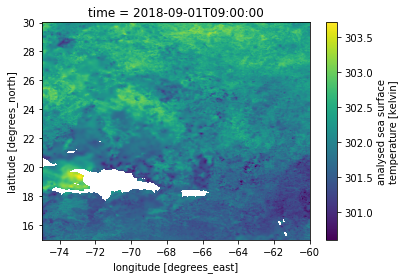

In [24]:
subset_mur.analysed_sst.plot()

## Now we'll do a similar search and subset for another dataset, OSTIA SST
Reuse the podaacpy search steps and search criteria used with the MUR dataset.

In [25]:
dresult_ostia = p.dataset_search(keyword='ostia', start_time=start_time, end_time=end_time)

In [26]:
dataset_id_ostia = get_podaac_datasetid(dresult_ostia)
dataset_id_ostia

'PODAAC-GHOST-4FK02'

In [27]:
gresult_ostia = p.granule_search(dataset_id=dataset_id_ostia,
                                 start_time=start_time,
                                 end_time=start_time,
                                 items_per_page='50')
urls = d.mine_drive_urls_from_granule_search(granule_search_response=gresult_ostia)
urls_ostia = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') 
              for w in urls]
urls_ostia

['https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/243/20180831120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/244/20180901120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc']

In [28]:
# We'll use the second url, because its timestamp (2018-9-1) matches that of the first MUR url.
ds_sst_ostia = xr.open_dataset(urls_ostia[1])
subset_ostia = ds_sst_ostia.sel(**sel_bbox)

In [29]:
# size in MB
subset_ostia.nbytes/1e6

1.442408

In [30]:
subset_ostia.load()

<xarray.Dataset>
Dimensions:           (lat: 300, lon: 300, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2018-09-01T12:00:00
  * lat               (lat) float32 15.025 15.075 15.125 ... 29.925 29.975
  * lon               (lon) float32 -74.975 -74.925 -74.875 ... -60.075 -60.025
Data variables:
    analysed_sst      (time, lat, lon) float32 301.33 301.32 ... 302.24
    analysis_error    (time, lat, lon) float32 0.19 0.19 0.19 ... 0.17 0.17 0.17
    sea_ice_fraction  (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mask              (time, lat, lon) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes:
    Conventions:                CF-1.4
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created f

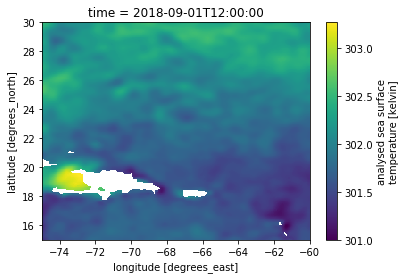

In [31]:
subset_ostia.analysed_sst.plot();

Let's plot it using `cartopy`, for a better map presentation.

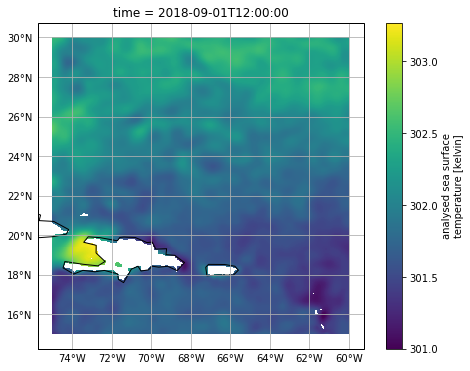

In [32]:
fig, ax = plt.subplots(figsize=(8, 6), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# subset_ostia.analysed_sst.plot(ax=ax, transform=ccrs.PlateCarree())
subset_ostia.analysed_sst.plot(ax=ax)
# Actually, the cartopy coastline is awful at this scale ...
ax.coastlines();
# Use ax.set_extent() to remove the buffer that got added around the data?

## Compare the two datasets by regridding MUR to OSTIA's grid
Regridding will allow us to make a direct comparison (via a simple difference), and to use OSTIA's nicer land mask. Regridding will be done using `interp_like`.

### Interpolation and masking
Interpolate the MUR data onto the OSTIA spatial grid, then mask it. Use `interp_like()` to interpolate the data in space for a single time step. Then use the OSTIA mask on the interpolated MUR SST data.

In [33]:
subset_mur_interp = subset_mur.isel(time=0).interp_like(subset_ostia)
subset_mur_masked = subset_mur_interp.where(subset_ostia.mask==1)

In [34]:
# print out the lat and lon for each dataset, to show they're now on the same grid
print(subset_mur_masked.lon[0:10].data)
print(subset_ostia.lon[0:10].data)
print(subset_mur_masked.lat[0:10].data)
print(subset_ostia.lat[0:10].data)

[-74.97499847 -74.92500305 -74.875      -74.82499695 -74.77500153
 -74.72499847 -74.67500305 -74.625      -74.57499695 -74.52500153]
[-74.975 -74.925 -74.875 -74.825 -74.775 -74.725 -74.675 -74.625 -74.575
 -74.525]
[15.02499962 15.07499981 15.125      15.17500019 15.22500038 15.27499962
 15.32499981 15.375      15.42500019 15.47500038]
[15.025 15.075 15.125 15.175 15.225 15.275 15.325 15.375 15.425 15.475]


In [35]:
subset_ostia.analysed_sst

<xarray.DataArray 'analysed_sst' (time: 1, lat: 300, lon: 300)>
array([[[301.33   , 301.32   , ..., 301.59   , 301.58   ],
        [301.34   , 301.34   , ..., 301.58   , 301.58   ],
        ...,
        [302.5    , 302.49   , ..., 302.24   , 302.25   ],
        [302.5    , 302.5    , ..., 302.22998, 302.24   ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-01T12:00:00
  * lat      (lat) float32 15.025 15.075 15.125 15.175 ... 29.875 29.925 29.975
  * lon      (lon) float32 -74.975 -74.925 -74.875 ... -60.125 -60.075 -60.025
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    source:         AVHRR18_G-NAVO-L2P-V1.0, AVHRR19_G-NAVO-L2P-V1.0, AVHRR_S...
    reference:      C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. F...
    comment:         OSTIA foundation SST

In [36]:
subset_ostia.analysed_sst.dtype, subset_mur_masked.analysed_sst.dtype

(dtype('float32'), dtype('float64'))

Calculate a new variable, `diff`, as the difference between OSTIA and MUR SST

In [37]:
diff = subset_ostia.analysed_sst - subset_mur_masked.analysed_sst

In [38]:
diff

<xarray.DataArray 'analysed_sst' (time: 1, lat: 300, lon: 300)>
array([[[ 0.321977,  0.113031, ..., -0.10524 , -0.1735  ],
        [ 0.296736,  0.163767, ..., -0.038002, -0.078508],
        ...,
        [-0.421493, -0.386509, ..., -0.220498, -0.210248],
        [-0.433242, -0.421492, ..., -0.166762, -0.162514]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-09-01T12:00:00
  * lat      (lat) float32 15.025 15.075 15.125 15.175 ... 29.875 29.925 29.975
  * lon      (lon) float32 -74.975 -74.925 -74.875 ... -60.125 -60.075 -60.025

Plot maps of MUR and OSTIA SST, followed by a difference map.

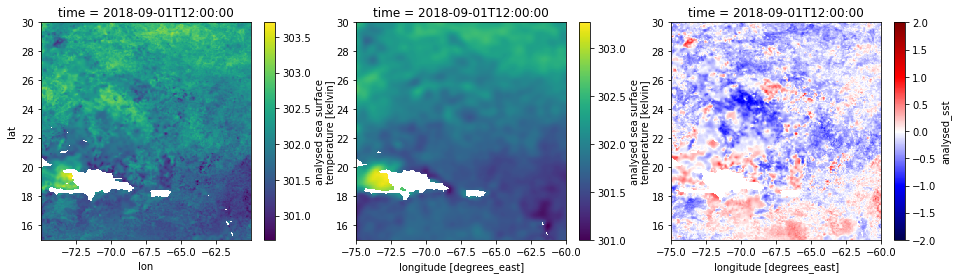

In [39]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

subset_mur_masked.analysed_sst.plot(ax=axes[0])
subset_ostia.analysed_sst.plot(ax=axes[1])
diff.plot(ax=axes[2], vmin=-2, vmax=2, cmap='seismic')

axes[1].set_ylabel('')
axes[2].set_ylabel('');

**NOTES:**
- `subset_mur_masked` lost the original `lon` and `lat` attributes on interpolation, so the axis labels are limited to the dimension (coordinate) names
- **TODO: change the cmap label/caption in plot 3 so it reflects that it's a diff, and the units**

## Histogram and subplots

* Create a figure with two axes using `plt.supplots()`
* Plot overlaid MUR and OSTIA SST histograms on the first subplot using [.plot.hist()](http://xarray.pydata.org/en/stable/generated/xarray.plot.hist.html), and the difference histogram on the second subplot.

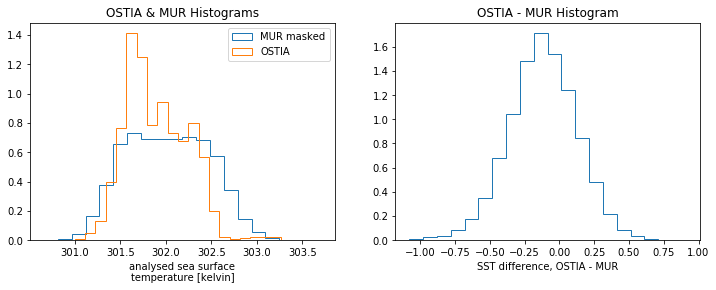

In [40]:
fig, axes = plt.subplots(ncols=2,figsize=(12,4))

subset_mur_masked.analysed_sst.plot.hist(bins=20,ax=axes[0],density = True,histtype='step',
                                         label='MUR masked')
subset_ostia.analysed_sst.plot.hist(bins=20,ax=axes[0],density = True,histtype='step',
                                    label='OSTIA')
diff.plot.hist(bins=20,ax=axes[1],density = True,histtype='step')

axes[0].legend(loc='best')
axes[0].set_title('OSTIA & MUR Histograms')
axes[1].set_xlabel('SST difference, OSTIA - MUR')
axes[1].set_title('OSTIA - MUR Histogram');

## Use xarray and OPeNDAP to open multi-file datasets with lazy loading
When you open a multi-file dataset, xarray uses **Dask** for lasy loading.  A subsequent tutorial will go into much more depth on Dask.
* Lazy loading: It mostly just loads the metadata. You can do data searching, selecting, subsetting without actually loading the data. 
* Here we have loaded in 15 days of data for two very high resolution SST global datasets.  Before we actually load the data, we are going to want to do some subsetting so that it will fit into our memory.
* Notice below when you print out the dataset details that they are all stored as dask.array types.

In [41]:
dsmf_mur = xr.open_mfdataset(urls_mur, coords='minimal')
dsmf_ostia = xr.open_mfdataset(urls_ostia, coords='minimal')

In [42]:
dsmf_mur

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 15)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
  * time              (time) datetime64[ns] 2018-09-01T09:00:00 ... 2018-09-15T09:00:00
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<shape=(15, 17999, 36000), chunksize=(1, 17999, 36000)>
    analysis_error    (time, lat, lon) float32 dask.array<shape=(15, 17999, 36000), chunksize=(1, 17999, 36000)>
    mask              (time, lat, lon) float32 dask.array<shape=(15, 17999, 36000), chunksize=(1, 17999, 36000)>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<shape=(15, 17999, 36000), chunksize=(1, 17999, 36000)>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<shape=(15, 17999, 36000), chunksize=(1, 17999, 36000)>
Attributes:
    Conventions:                CF-1.5
    title:                   

Compare time series of the spatially averaged SST as esatimated by MUR and OSTIA. Let's convert from Kelvin to Celsius, too.

In [43]:
selmf_bbox = dict(lat=slice(25,26), lon=slice(-61,-60))

subsetmf_mur = dsmf_mur.sel(**selmf_bbox).mean({'lat','lon'})
subsetmf_ostia = dsmf_ostia.sel(**selmf_bbox).mean({'lat','lon'})

In [44]:
subsetmf_mur

<xarray.Dataset>
Dimensions:           (time: 15)
Coordinates:
  * time              (time) datetime64[ns] 2018-09-01T09:00:00 ... 2018-09-15T09:00:00
Data variables:
    analysed_sst      (time) float32 dask.array<shape=(15,), chunksize=(1,)>
    analysis_error    (time) float32 dask.array<shape=(15,), chunksize=(1,)>
    mask              (time) float32 dask.array<shape=(15,), chunksize=(1,)>
    sea_ice_fraction  (time) float32 dask.array<shape=(15,), chunksize=(1,)>
    dt_1km_data       (time) timedelta64[ns] dask.array<shape=(15,), chunksize=(1,)>

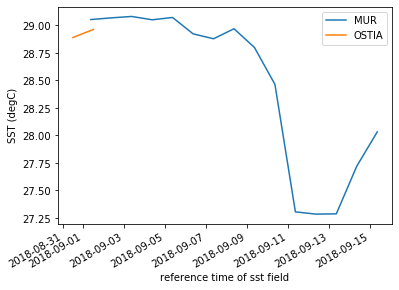

In [45]:
fig, ax = plt.subplots()
(subsetmf_mur.analysed_sst - 273.15).plot(label='MUR')
(subsetmf_ostia.analysed_sst - 273.15).plot(label='OSTIA')
ax.set_ylabel('SST (degC)')
ax.legend();

**TODO: Why is OSTIA now failing to plot beyond the first two time steps, when it worked fine a day ago?**

TO-DO: Plot a line indicating the date we used in the map comparison above.